Use conjugate priors in a Gaussian mixture model for clustering. Put a Dirichlet prior on the cluster probabilities, a multivariate Normal on the cluster means, and independent Gamma distributions on the variances of each feature.

# a) Implement a Gibbs sampler to generate samples from the posterior distribution of cluster memberships.

First, I will use K-means to initialize the clusters intelligently.

In [1]:
import numpy
import math
import random

def Kmeans(data, K):
    """ Initializes the clusters intelligently using K-means. Copied from homework #4. """
    
    numpy.random.seed(1)
    # randomly generate K means
    means = []
    for k in range(K):
        meank = []
        # for each attribute, generate a mean between the min and max value of that attribute
        for col in range(data.shape[1]):
            meank.append(random.uniform(numpy.amin(data[:, col]), numpy.amax(data[:, col])))
        # add this mean to the list
        means.append(meank)
    means = numpy.array(means)
    
    # store whether the cluster assignments have been changed in a given iteration
    changed = True
    
    # while the cluster assignments are still changing, assign values to their nearest cluster and calculate new means
    while changed:
        # set changed to False for this round
        changed = False
        
        # calculate the Euclidian distance from each instance to each cluster mean
        dists = numpy.empty((data.shape[0], K))
        for k in range(K):
            dists[:, k] = numpy.apply_along_axis(lambda x: math.sqrt(numpy.sum((x-means[k, :])**2)), 1, data)
        
        # find the nearest cluster center for each instance
        clusters = numpy.argmin(dists, axis = 1)
        
        # calculate the new mean of each cluster
        for k in range(K):
            clusterk = 1*(clusters == k)
            # if this cluster doesn't have any instances in it, try again
            if numpy.sum(clusterk) == 0:
                return Kmeans(data, K)
            # loop through each attribute
            for col in range(data.shape[1]):
                meanka = numpy.sum(data[:, col]*clusterk)/numpy.sum(clusterk)
                # if the new mean of this cluster is different from the old mean, turn changed to true
                if meanka != means[k, col]:
                    changed = True
                # add the new mean to the array
                means[k, col] = meanka
    
    # once the cluster assignments stop changing, return the assignments and the means
    return clusters, means

Now I can use clusters generated by K-means to start Gibbs sampling.

In [2]:
import scipy.stats
import matplotlib.pyplot as plt

def GibbsSample(data, K, iters, prior_alpha, prior_mean, prior_variance, prior_a, prior_b):
    """ Iteratively samples cluster assignments and parameter values to approximate sampling from the posterior. """
    
    numpy.random.seed(1)
    
    # run K-means on the data
    clusters, means = Kmeans(data, K)
    
    # an empty array of cluster assignments to hold the results of each iteration
    Allclusters = numpy.empty((iters+1, data.shape[0]))
    # and put the initial clusters from K-means in it
    Allclusters[0, :] = clusters
    # an empty array of cluster proporitions
    pis = numpy.empty((iters, K))
    # cluster means
    mus = numpy.empty((iters, K, data.shape[1]))
    # and cluster variances
    sigmas = numpy.empty((iters, K, data.shape[1]))
    # also save the log likelihood
    likelihood = numpy.zeros(iters)
    
    # now iteratively sample for the designated number of iterations
    for i in range(iters):
        # create a list of alpha parameters on the Dirichlet so those can be handled together
        Dirichlet_alpha = numpy.empty(K)
        
        # update the other parameters for each cluster separately
        for k in range(K):
            # the number of instances in this cluster
            nk = numpy.sum(1*(Allclusters[i, :] == k))
            # if a cluster is empty or only has one instance in it, sample from the prior
            if nk <= 5:
                mus[i, k, :] = numpy.random.multivariate_normal(prior_mean*numpy.ones(data.shape[1]),
                                                                prior_variance*numpy.identity(data.shape[1]))
                for d in range(data.shape[1]):
                    sigmas[i, k, d] = numpy.random.gamma(prior_a, 1/prior_b)
            # otherwise update the parameters and sample from the posterior
            else:
                # the variance among instances in this cluster
                hk = numpy.linalg.inv(numpy.diag(numpy.var(data[Allclusters[i, :] == k, :], axis = 0)))
            
                # update the prior parameters to posteriors based on the current cluster assignments (conjugate update)
                # first the parameters on mu
                Normal_variance = numpy.linalg.inv(numpy.identity(hk.shape[0])*(prior_variance + nk*hk))
                Normal_mean = numpy.dot(prior_variance*prior_mean + nk*numpy.dot(hk,
                                        numpy.mean(data[Allclusters[i, :] == k, :], axis = 0)), Normal_variance)
                # now I can draw a value of mu
                mus[i, k, :] = numpy.random.multivariate_normal(Normal_mean, Normal_variance)
                
                # update the parameters on the variance
                Gamma_a = prior_a + nk/2
                Gamma_b = prior_b + numpy.sum(numpy.apply_along_axis(lambda d: (d - mus[i, k, :])**2, 1, data[Allclusters[i, :] == k, :]), axis = 0)/2
                # sample from the posterior on sigma
                for d in range(data.shape[1]):
                    sigmas[i, k, d] = numpy.random.gamma(Gamma_a, 1/Gamma_b[d])
            
            # update the parameters on pi
            Dirichlet_alpha[k] = prior_alpha + nk
        
        # sample from the posterior on pi for all of the clusters at once
        pis[i, :] = numpy.random.dirichlet(Dirichlet_alpha)
        
        # use the new parameter values to update the cluster assignments
        for n in range(data.shape[0]):
            qn = numpy.empty(K)
            for k in range(K):
                qn[k] = pis[i, k]*scipy.stats.multivariate_normal.pdf(data[n, :], mean = mus[i, k, :], cov = numpy.linalg.inv(numpy.diag(sigmas[i, k, :])))
            qn = qn/numpy.sum(qn)
            z = int(numpy.random.choice(numpy.arange(K), p = qn))
            Allclusters[i+1, n] = z
            likelihood[i] += numpy.log(qn[z])
    
    return Allclusters, pis, mus, sigmas, likelihood

Now I'm going to load some of the data sets we used in homework 4 and cluster those.

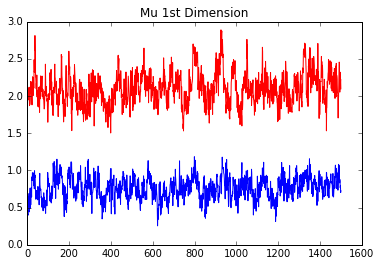

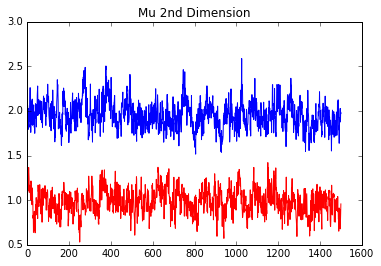

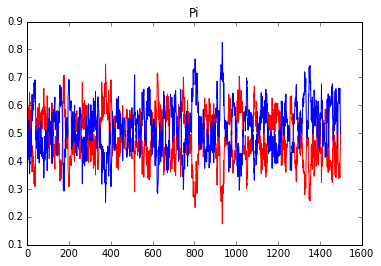

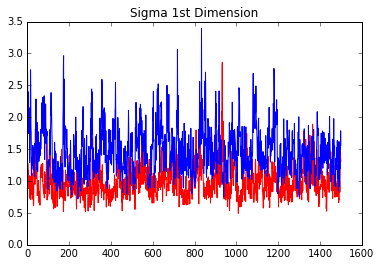

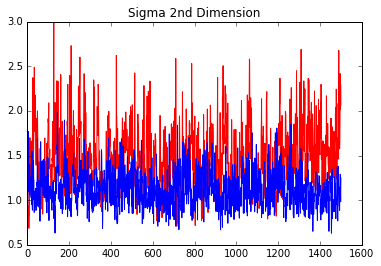

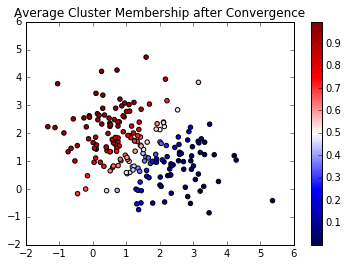

In [11]:
import matplotlib.pyplot as plt

S1data = numpy.loadtxt("S1train.csv", delimiter = ",", usecols = (1, 2))
S1clusters, S1pi, S1mu, S1sigma, S1likelihood = GibbsSample(S1data, 2, 1500, 10, 1.5, .5, 1, 1)
plt.plot(numpy.arange(1500), S1mu[:, 0, 0], "r", numpy.arange(1500), S1mu[:, 1, 0], "b")
plt.title("Mu 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1mu[:, 0, 1], "r", numpy.arange(1500), S1mu[:, 1, 1], "b")
plt.title("Mu 2nd Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1pi[:, 0], "r", numpy.arange(1500), S1pi[:, 1], "b")
plt.title("Pi")
plt.show()
plt.plot(numpy.arange(1500), S1sigma[:, 0, 0], "r", numpy.arange(1500), S1sigma[:, 1, 0], "b")
plt.title("Sigma 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1sigma[:, 0, 1], "r", numpy.arange(1500), S1sigma[:, 1, 1], "b")
plt.title("Sigma 2nd Dimension")
plt.show()

# plot the clusters
plt.scatter(S1data[:, 0], S1data[:, 1], c = numpy.mean(S1clusters[-1000:, :], axis = 0), cmap = "seismic")
plt.title("Average Cluster Membership after Convergence")
plt.colorbar()
plt.show()

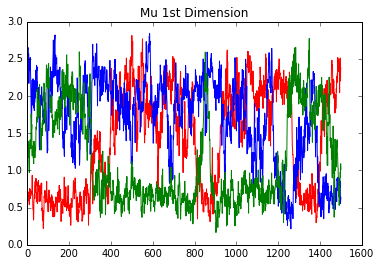

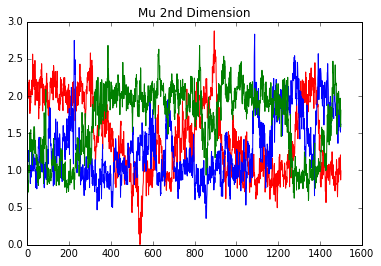

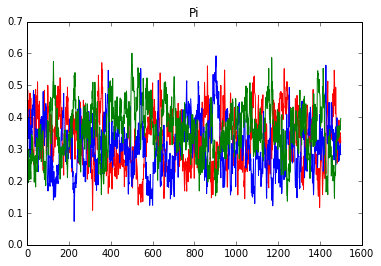

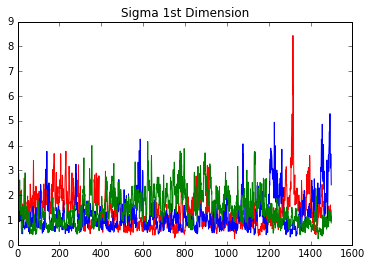

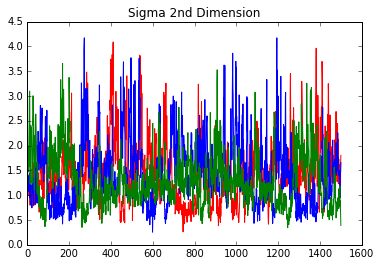

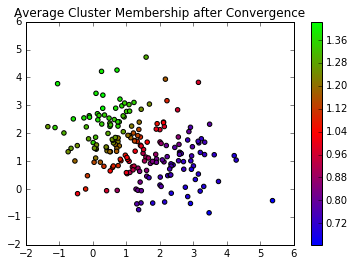

In [5]:
# first synthetic data set with three clusters
S1clusters3, S1pi3, S1mu3, S1sigma3, S1likelihood3 = GibbsSample(S1data, 3, 1500, 10, 1.5, 2, 1, 1)
plt.plot(numpy.arange(1500), S1mu3[:, 0, 0], "r", numpy.arange(1500), S1mu3[:, 1, 0], "b",
         numpy.arange(1500), S1mu3[:, 2, 0], "g")
plt.title("Mu 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1mu3[:, 0, 1], "r", numpy.arange(1500), S1mu3[:, 1, 1], "b",
        numpy.arange(1500), S1mu3[:, 2, 1], "g")
plt.title("Mu 2nd Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1pi3[:, 0], "r", numpy.arange(1500), S1pi3[:, 1], "b",
         numpy.arange(1500), S1pi3[:, 2], "g")
plt.title("Pi")
plt.show()
plt.plot(numpy.arange(1500), S1sigma3[:, 0, 0], "r", numpy.arange(1500), S1sigma3[:, 1, 0], "b",
         numpy.arange(1500), S1sigma3[:, 2, 0], "g")
plt.title("Sigma 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1sigma3[:, 0, 1], "r", numpy.arange(1500), S1sigma3[:, 1, 1], "b",
         numpy.arange(1500), S1sigma3[:, 2, 1], "g")
plt.title("Sigma 2nd Dimension")
plt.show()

# plot the clusters
plt.scatter(S1data[:, 0], S1data[:, 1], c = numpy.mean(S1clusters3[-1000:, :], axis = 0), cmap = "brg")
plt.title("Average Cluster Membership after Convergence")
plt.colorbar()
plt.show()

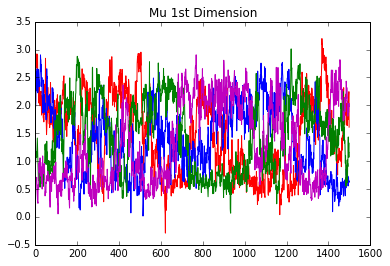

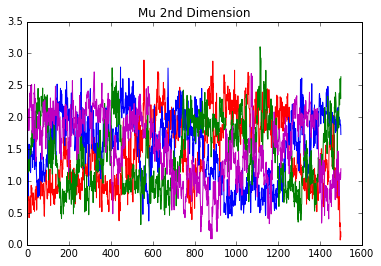

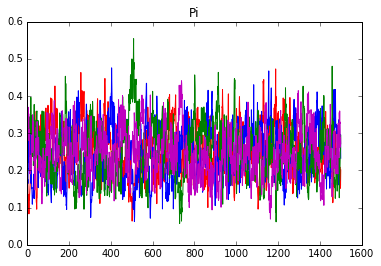

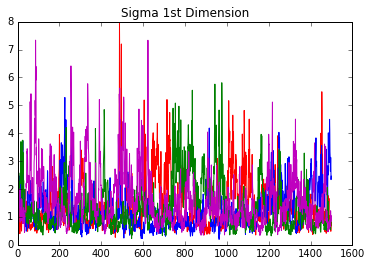

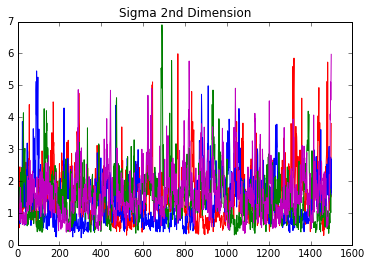

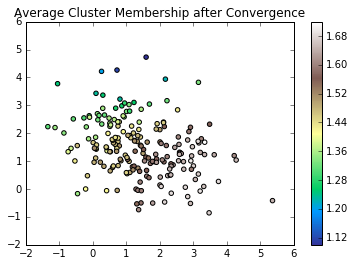

In [6]:
# first synthetic data set with four clusters
S1clusters4, S1pi4, S1mu4, S1sigma4, S1likelihood4 = GibbsSample(S1data, 4, 1500, 10, 1.5, 2, 1, 1)
plt.plot(numpy.arange(1500), S1mu4[:, 0, 0], "r", numpy.arange(1500), S1mu4[:, 1, 0], "b",
         numpy.arange(1500), S1mu4[:, 2, 0], "g", numpy.arange(1500), S1mu4[:, 3, 0], "m")
plt.title("Mu 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1mu4[:, 0, 1], "r", numpy.arange(1500), S1mu4[:, 1, 1], "b",
         numpy.arange(1500), S1mu4[:, 2, 1], "g", numpy.arange(1500), S1mu4[:, 3, 1], "m")
plt.title("Mu 2nd Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1pi4[:, 0], "r", numpy.arange(1500), S1pi4[:, 1], "b",
         numpy.arange(1500), S1pi4[:, 2], "g", numpy.arange(1500), S1pi4[:, 3], "m")
plt.title("Pi")
plt.show()
plt.plot(numpy.arange(1500), S1sigma4[:, 0, 0], "r", numpy.arange(1500), S1sigma4[:, 1, 0], "b",
         numpy.arange(1500), S1sigma4[:, 2, 0], "g", numpy.arange(1500), S1sigma4[:, 3, 0], "m")
plt.title("Sigma 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), S1sigma4[:, 0, 1], "r", numpy.arange(1500), S1sigma4[:, 1, 1], "b",
         numpy.arange(1500), S1sigma4[:, 2, 1], "g", numpy.arange(1500), S1sigma4[:, 3, 1], "m")
plt.title("Sigma 2nd Dimension")
plt.show()

# plot the clusters
plt.scatter(S1data[:, 0], S1data[:, 1], c = numpy.mean(S1clusters4[-1000:, :], axis = 0), cmap = "terrain")
plt.title("Average Cluster Membership after Convergence")
plt.colorbar()
plt.show()

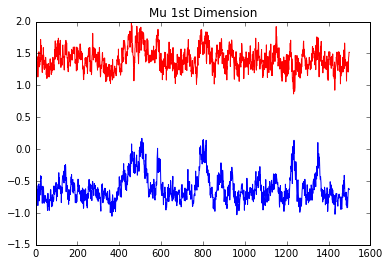

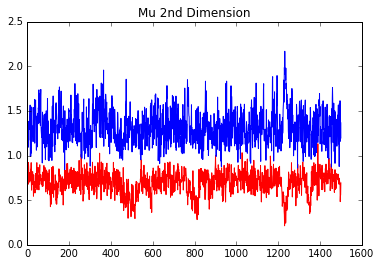

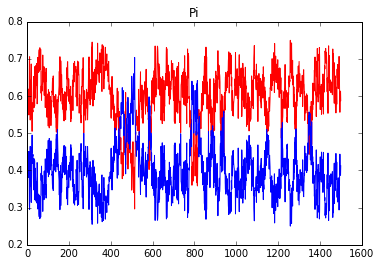

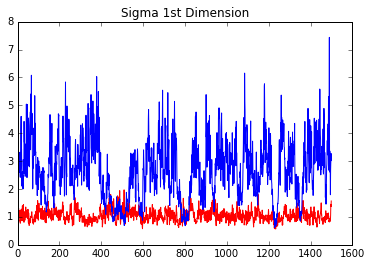

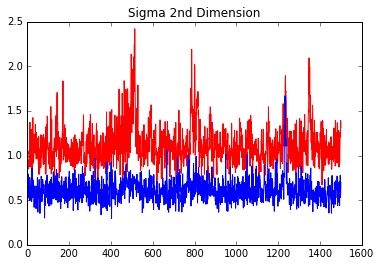

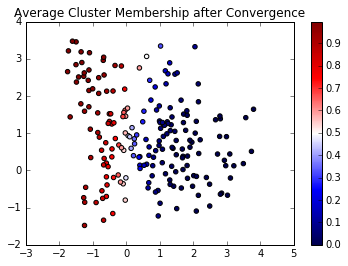

In [19]:
# second synthetic data set
S2data = numpy.loadtxt("S2train.csv", delimiter = ",", usecols = (1, 2))
S2clusters, S2pi, S2mu, S2sigma, S2likelihood = GibbsSample(S2data, 2, 1500, 20, 1.5, .5, 2, 1)
plt.plot(numpy.arange(1500), S2mu[:, 0, 0], "r", numpy.arange(1500), S2mu[:, 1, 0], "b")
plt.title("Mu 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), S2mu[:, 0, 1], "r", numpy.arange(1500), S2mu[:, 1, 1], "b")
plt.title("Mu 2nd Dimension")
plt.show()
plt.plot(numpy.arange(1500), S2pi[:, 0], "r", numpy.arange(1500), S2pi[:, 1], "b")
plt.title("Pi")
plt.show()
plt.plot(numpy.arange(1500), S2sigma[:, 0, 0], "r", numpy.arange(1500), S2sigma[:, 1, 0], "b")
plt.title("Sigma 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), S2sigma[:, 0, 1], "r", numpy.arange(1500), S2sigma[:, 1, 1], "b")
plt.title("Sigma 2nd Dimension")
plt.show()

# plot the clusters
plt.scatter(S2data[:, 0], S2data[:, 1], c = numpy.mean(S2clusters[-1000:, :], axis = 0), cmap = "seismic")
plt.title("Average Cluster Membership after Convergence")
plt.colorbar()
plt.show()

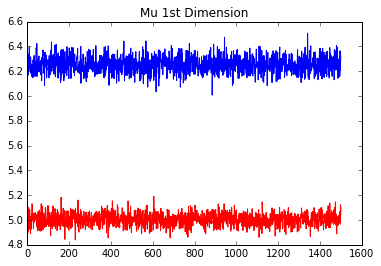

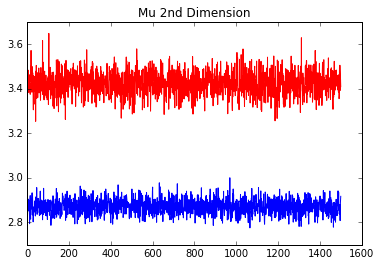

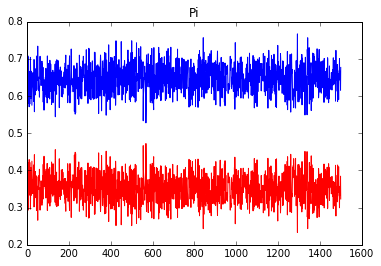

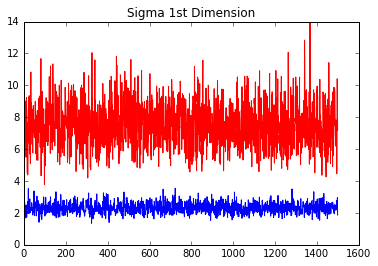

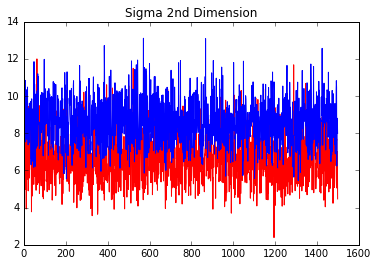

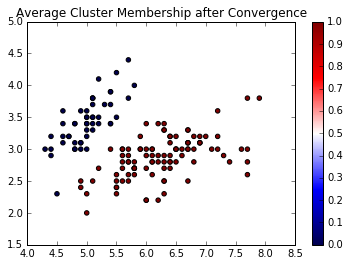

In [20]:
# Iris data set with two clusters
irisdata = numpy.loadtxt("iris_features.csv", delimiter = ",", skiprows = 1)
irisclusters2, irispi2, irismu2, irissigma2, irislikelihood2 = GibbsSample(irisdata, 2, 1500, 10, 2, .5, 2, .5)
plt.plot(numpy.arange(1500), irismu2[:, 0, 0], "r", numpy.arange(1500), irismu2[:, 1, 0], "b")
plt.title("Mu 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), irismu2[:, 0, 1], "r", numpy.arange(1500), irismu2[:, 1, 1], "b")
plt.title("Mu 2nd Dimension")
plt.show()
plt.plot(numpy.arange(1500), irispi2[:, 0], "r", numpy.arange(1500), irispi2[:, 1], "b")
plt.title("Pi")
plt.show()
plt.plot(numpy.arange(1500), irissigma2[:, 0, 0], "r", numpy.arange(1500), irissigma2[:, 1, 0], "b")
plt.title("Sigma 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), irissigma2[:, 0, 1], "r", numpy.arange(1500), irissigma2[:, 1, 1], "b")
plt.title("Sigma 2nd Dimension")
plt.show()

# plot the clusters
plt.scatter(irisdata[:, 0], irisdata[:, 1], c = numpy.mean(irisclusters2[-1000:, :], axis = 0), cmap = "seismic")
plt.title("Average Cluster Membership after Convergence")
plt.colorbar()
plt.show()

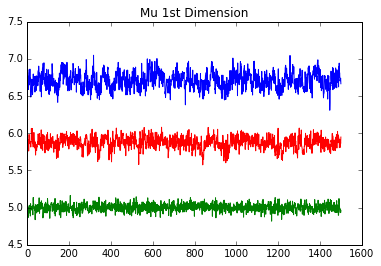

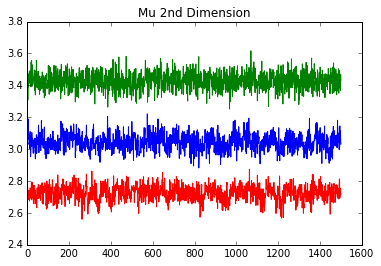

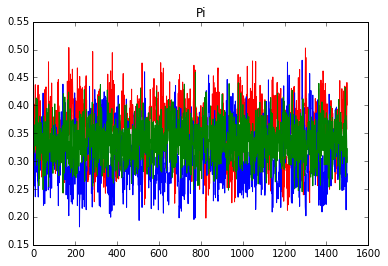

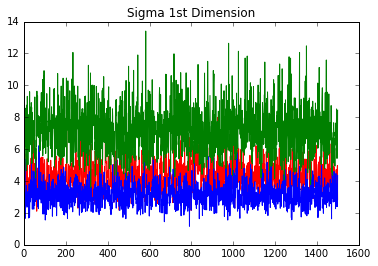

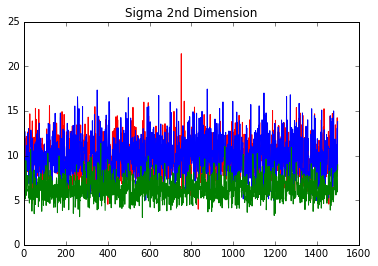

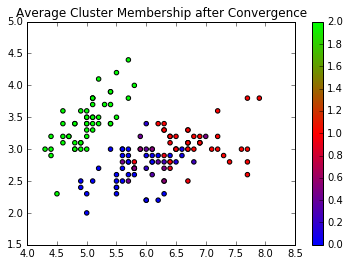

In [23]:
# Iris data set with three clusters
irisclusters3, irispi3, irismu3, irissigma3, irislikelihood3 = GibbsSample(irisdata, 3, 1500, 10, 2, .5, 1, .5)
plt.plot(numpy.arange(1500), irismu3[:, 0, 0], "r", numpy.arange(1500), irismu3[:, 1, 0], "b",
         numpy.arange(1500), irismu3[:, 2, 0], "g")
plt.title("Mu 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), irismu3[:, 0, 1], "r", numpy.arange(1500), irismu3[:, 1, 1], "b",
         numpy.arange(1500), irismu3[:, 2, 1], "g")
plt.title("Mu 2nd Dimension")
plt.show()
plt.plot(numpy.arange(1500), irispi3[:, 0], "r", numpy.arange(1500), irispi3[:, 1], "b",
         numpy.arange(1500), irispi3[:, 2], "g")
plt.title("Pi")
plt.show()
plt.plot(numpy.arange(1500), irissigma3[:, 0, 0], "r", numpy.arange(1500), irissigma3[:, 1, 0], "b",
         numpy.arange(1500), irissigma3[:, 2, 0], "g")
plt.title("Sigma 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), irissigma3[:, 0, 1], "r", numpy.arange(1500), irissigma3[:, 1, 1], "b",
         numpy.arange(1500), irissigma3[:, 2, 1], "g")
plt.title("Sigma 2nd Dimension")
plt.show()

# plot the clusters
plt.scatter(irisdata[:, 0], irisdata[:, 1], c = numpy.mean(irisclusters3[-1000:, :], axis = 0), cmap = "brg")
plt.title("Average Cluster Membership after Convergence")
plt.colorbar()
plt.show()

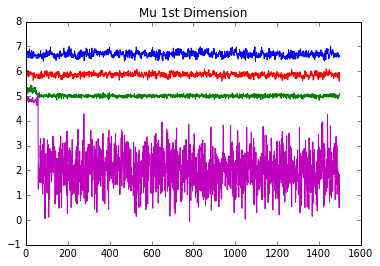

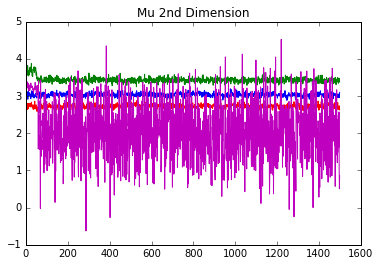

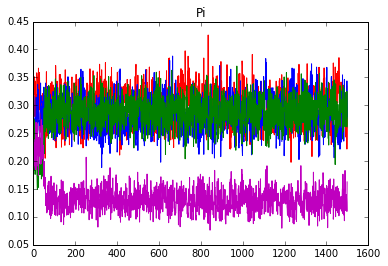

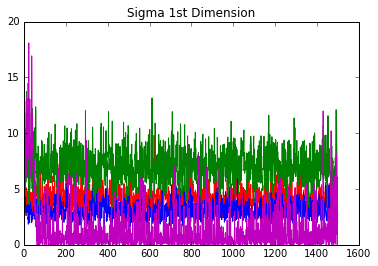

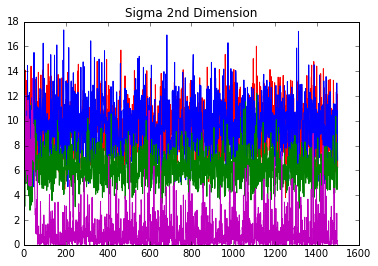

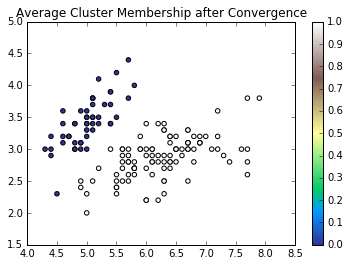

In [27]:
# Iris data set with four clusters
irisclusters4, irispi4, irismu4, irissigma4, irislikelihood4 = GibbsSample(irisdata, 4, 1500, 40, 2, .5, .5, .5)
plt.plot(numpy.arange(1500), irismu4[:, 0, 0], "r", numpy.arange(1500), irismu4[:, 1, 0], "b",
         numpy.arange(1500), irismu4[:, 2, 0], "g", numpy.arange(1500), irismu4[:, 3, 0], "m")
plt.title("Mu 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), irismu4[:, 0, 1], "r", numpy.arange(1500), irismu4[:, 1, 1], "b",
         numpy.arange(1500), irismu4[:, 2, 1], "g", numpy.arange(1500), irismu4[:, 3, 1], "m")
plt.title("Mu 2nd Dimension")
plt.show()
plt.plot(numpy.arange(1500), irispi4[:, 0], "r", numpy.arange(1500), irispi4[:, 1], "b",
         numpy.arange(1500), irispi4[:, 2], "g", numpy.arange(1500), irispi4[:, 3], "m")
plt.title("Pi")
plt.show()
plt.plot(numpy.arange(1500), irissigma4[:, 0, 0], "r", numpy.arange(1500), irissigma4[:, 1, 0], "b",
         numpy.arange(1500), irissigma4[:, 2, 0], "g", numpy.arange(1500), irissigma4[:, 3, 0], "m")
plt.title("Sigma 1st Dimension")
plt.show()
plt.plot(numpy.arange(1500), irissigma4[:, 0, 1], "r", numpy.arange(1500), irissigma4[:, 1, 1], "b",
         numpy.arange(1500), irissigma4[:, 2, 1], "g", numpy.arange(1500), irissigma4[:, 3, 1], "m")
plt.title("Sigma 2nd Dimension")
plt.show()

# plot the clusters
plt.scatter(irisdata[:, 0], irisdata[:, 1], c = numpy.mean(irisclusters2[-1000:, :], axis = 0), cmap = "terrain")
plt.title("Average Cluster Membership after Convergence")
plt.colorbar()
plt.show()

# b) Estimate the pairwise co-clustering matrix.

In [36]:
def coclustering(clusters):
    """ Returns the pairwise co-clustering matrix given a list of clusters sampled for a given data set. """
    
    # create the empty matrix
    coclusters = numpy.empty((clusters.shape[1], clusters.shape[1]))
    
    # loop through each pair of points
    for i in range(clusters.shape[1]):
        for j in range(clusters.shape[1]):
            coclusters[i, j] = numpy.sum(1*(clusters[-1000:, i] == clusters[-1000:, j]))/1000
    
    return coclusters

Now I can display the coclustering matricies for each of the data sets clustered above.

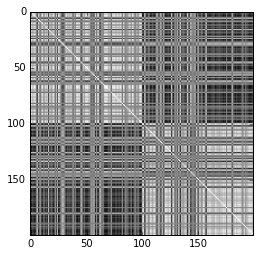

In [37]:
# 1st synthetic data set
coclusters = coclustering(S1clusters)
plt.imshow(coclusters, cmap = "gray")
plt.show()

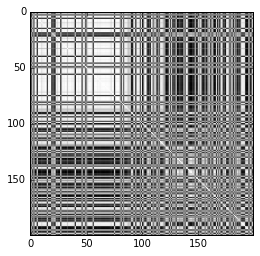

In [38]:
# 2nd synthetic data set
coclusters = coclustering(S2clusters)
plt.imshow(coclusters, cmap = "gray")
plt.show()

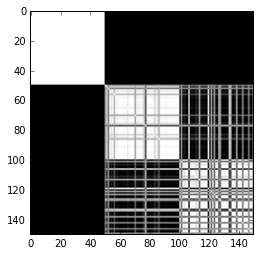

In [39]:
# iris data set
coclusters = coclustering(irisclusters3)
plt.imshow(coclusters, cmap = "gray")
plt.show()

# c) Estimate the log marginal likelihood of the training data.

In [16]:
def logmarginalL(likelihood):
    """ Given a list of log likelihoods of each iteration, returns the overal log marginal likelihood. """
    
    return (numpy.log(numpy.sum(numpy.exp(likelihood[-1000:] - numpy.mean(likelihood[-1000:]))))
            + numpy.mean(likelihood[-1000:]) + numpy.log(1/(1000+1)))

In [17]:
# likelihood of the 1st synthetic data set
print(logmarginalL(S1likelihood))

-45.6905648251


In [21]:
# likelihood of the 2nd synthetic data set
print(logmarginalL(S2likelihood))

-26.0345570935


In [22]:
# likelihood of the iris data set with 2 clusters
print(logmarginalL(irislikelihood2))

-0.00100444031679


In [25]:
# likelihood of the iris data set with 3 clusters
print(logmarginalL(irislikelihood3))

-7.70411275245


In [28]:
# likelihood of the iris data set with 4 clusters
print(logmarginalL(irislikelihood4))

-9.35665644078


# d) Plot and compare the results log-likelihood for different values of K for a few data sets. Does this metric tend to select a good value of K?

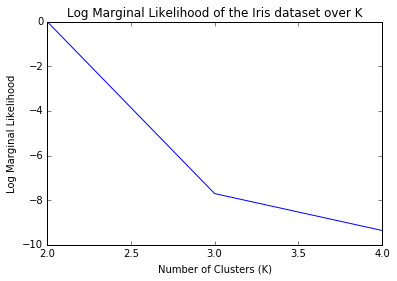

In [29]:
plt.plot(range(2, 5), [logmarginalL(irislikelihood2), logmarginalL(irislikelihood3), logmarginalL(irislikelihood4)],
        "b")
plt.title("Log Marginal Likelihood of the Iris dataset over K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Log Marginal Likelihood")
plt.show()

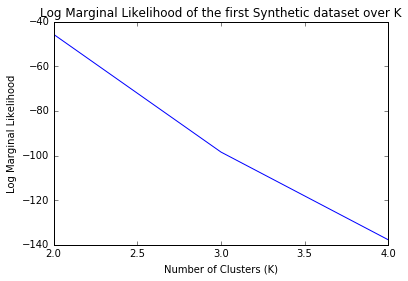

In [24]:
plt.plot(range(2, 5), [logmarginalL(S1likelihood), logmarginalL(S1likelihood3), logmarginalL(S1likelihood4)],
        "b")
plt.title("Log Marginal Likelihood of the first Synthetic dataset over K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Log Marginal Likelihood")
plt.show()

It seems that log marginal likelihood prefers lower values of K. This may be because, as I have found, the more clusters there are, the less stable they are.


# e) Plot contours of the marginal density function.

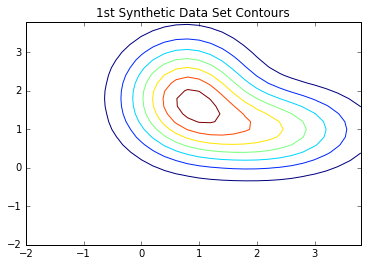

In [30]:
# for convenience, I'll use matplotlib's bivariate normal function
import matplotlib.mlab as mlab

# make the x and y coordinates of the grid
X, Y = numpy.meshgrid(numpy.arange(-2, 4, .2), numpy.arange(-2, 4, .2))
Z = numpy.zeros((30, 30))
# and the values at those points
for k in range(2):
    Z += numpy.mean(S1pi[-1000:, k])*mlab.bivariate_normal(
        X, Y, sigmax = numpy.mean(1/S1sigma[-1000:, k, 0]), sigmay = numpy.mean(1/S1sigma[-1000:, k, 1]),
        mux = numpy.mean(S1mu[-1000:, k, 0]), muy = numpy.mean(S1mu[-1000:, k, 1]))

plt.contour(X, Y, Z)
plt.title("1st Synthetic Data Set Contours")
plt.show()

For this data set, I put a prior on the mean with mean 1.5 and variance .5 and a prior on the variance with both a and b equal to 1. This reflects the prior parameters on the mean fairly well, with the center of the contour around 1.5 in both dimensions. This is probably in part due to the fact that I decided on the prior mean of 1.5 based on a glace at the data. The variance appears to be closer to 1.5 or 2 than my prior guess of 1 suggests.